# Spectral Diffusion for a Toy ${\rm SU}(2)$ Model using Group-Valued Score Matching

In this notebook, we apply the same machinery we used in the other notebook (where we trained a score network to learn the heat kernel and denoise the variance-expanding diffusion process) to learn a toy theory involving a single ${\rm SU}(2)$ matrix $U$ (one independent eigenangle $\theta$).

## Setup

In [1]:
# General imports
import math
import numpy as np
import torch

import tqdm.auto as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Imports from our repo
import sys
sys.path.insert(0, '..')  # repo source code

from src.linalg import trace, adjoint
from src.diffusion import VarianceExpandingDiffusion, VarianceExpandingDiffusionSUN
from src.sun import (
    proj_to_algebra, matrix_exp, matrix_log,
    random_sun_element, random_un_haar_element,
    group_to_coeffs, coeffs_to_group,
    extract_sun_algebra, embed_diag, mat_angle
)
from src.canon import canonicalize_sun
from src.heat import (
    #eucl_score_hk,
    log_sun_hk, sun_hk,
    sun_score_hk_old, sun_score_hk, 
    sample_sun_hk
)
from src.utils import grab, wrap
from src.devices import set_device, get_device, summary
from src.integrate import estimate_divergence

In [3]:
set_device('cuda', 0)
torch.set_default_dtype(torch.float64)
print(summary())

Using device: cuda:0 (NVIDIA GH200 120GB) with dtype: torch.float64


## Define a Target Theory and Generate Training Data

The target theory whose distribution we will try to reproduce is specified by a toy action of our choosing, which we define to be 
$$S[U] = -\beta \; {\rm Re}{\rm Tr}(U).$$

In [4]:
from src.action import SUNToyAction

# Instantiate and test a toy SU(2) matrix action
def _test_action():
    batch_size = 3
    Nc = 2
    U = random_sun_element(batch_size, Nc=2)

    action = SUNToyAction(beta=1.0)
    print('Action evaluated on configs:', grab(action(U)))

_test_action()

Action evaluated on configs: [-0.86051023 -0.90429657 -0.68759789]


In [5]:
class SUNToyPolynomialAction:
    def __init__(self, beta, coeffs=[1.0, 0.0, 0.0]):
        self.beta = beta
        self.coeffs = coeffs

    def __call__(self, U):
        Nc = U.size(-1)
        action_density = 0
        for i, c in enumerate(self.coeffs):
            action_density += c * torch.matrix_power(U, i+1)
        return -self.beta * trace(action_density).real / Nc


def _test_toy_polynomial_action():
    batch_size = 5
    Nc = 2
    U = random_sun_element(batch_size, Nc=2)

    beta = 1.0
    coeffs = [1.0, 1.0, 1.0]
    action = SUNToyPolynomialAction(beta, coeffs)

    S = action(U)
    print('Action evaluated on cfgs:', grab(S))

_test_toy_polynomial_action()    

Action evaluated on cfgs: [ 0.98823652 -0.53781171  0.92401762 -2.42225675 -1.27575103]


To generate configurations, we will use the Metropolis algorithm for simplicity.

In [6]:
def apply_metropolis(batch_size, Nc, action, num_steps, step_size):
    """Batched Metropolis sampler."""
    action_vals = []
    accept_rates = []
    
    U = random_sun_element(batch_size, Nc=Nc)
    for _ in range(num_steps):
        # Proposal
        V_re = torch.eye(Nc).repeat(batch_size, 1, 1) 
        V_im = step_size * torch.randn((batch_size, Nc, Nc))
        V = V_re + 1j*V_im
        V = torch.matrix_exp(1j*proj_to_algebra(V))  # random group noise
        Up = V @ U
        dS = action(Up) - action(U)

        # Accept / Reject
        r = torch.rand((batch_size,))  # accept w/ prob = exp(-dS)
        accept_mask = (r < torch.exp(-dS))[:, None, None]
        U = torch.where(accept_mask, Up, U)

        action_vals.append(grab(action(U).mean()))
        accept_rates.append(grab(torch.sum(accept_mask) / batch_size))

    return U, action_vals, accept_rates

In [7]:
# Define physical theory
beta = -1.0
#action = SUNToyAction(beta)
#action = SUNToyPolynomialAction(beta, [1.0, 0., 0.])
action = SUNToyPolynomialAction(beta, [0.17, -0.65, 1.22])
#action = SUNToyPolynomialAction(beta, [0.98, -0.63, -0.21])


# Generate samples
num_train = 2048
num_therm = 500
num_iters = 1_000
step_size = 0.9

U_train, action_vals, accept_rates = apply_metropolis(
    batch_size = num_train,
    Nc = 2,
    action = action,
    num_steps = num_therm + num_iters,
    step_size = step_size
)

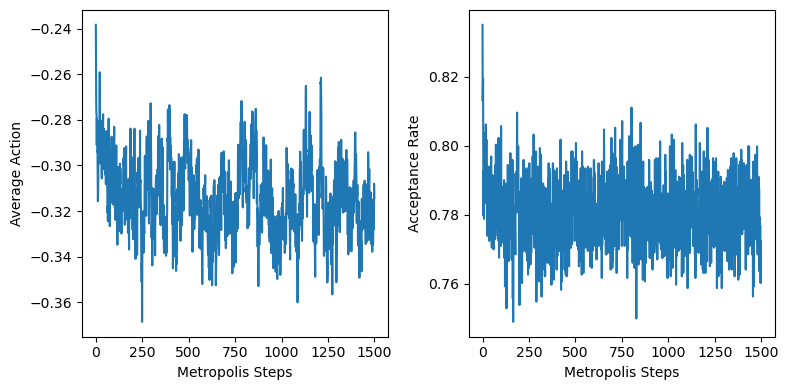

In [8]:
# Visualize Metropolis
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax in axes:
    ax.set_xlabel('Metropolis Steps')

axes[0].plot(action_vals)
axes[0].set_ylabel('Average Action')

axes[1].plot(accept_rates)
axes[1].set_ylabel('Acceptance Rate')

fig.tight_layout()
fig.show();

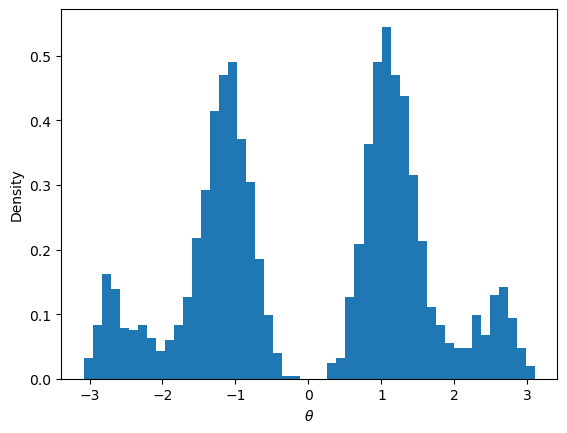

In [9]:
fig, ax = plt.subplots(1, 1)
ax.hist(grab(mat_angle(U_train)[0][:, 0]), bins=50, density=True)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel('Density')
#ax.set_yscale('log')
fig.show()

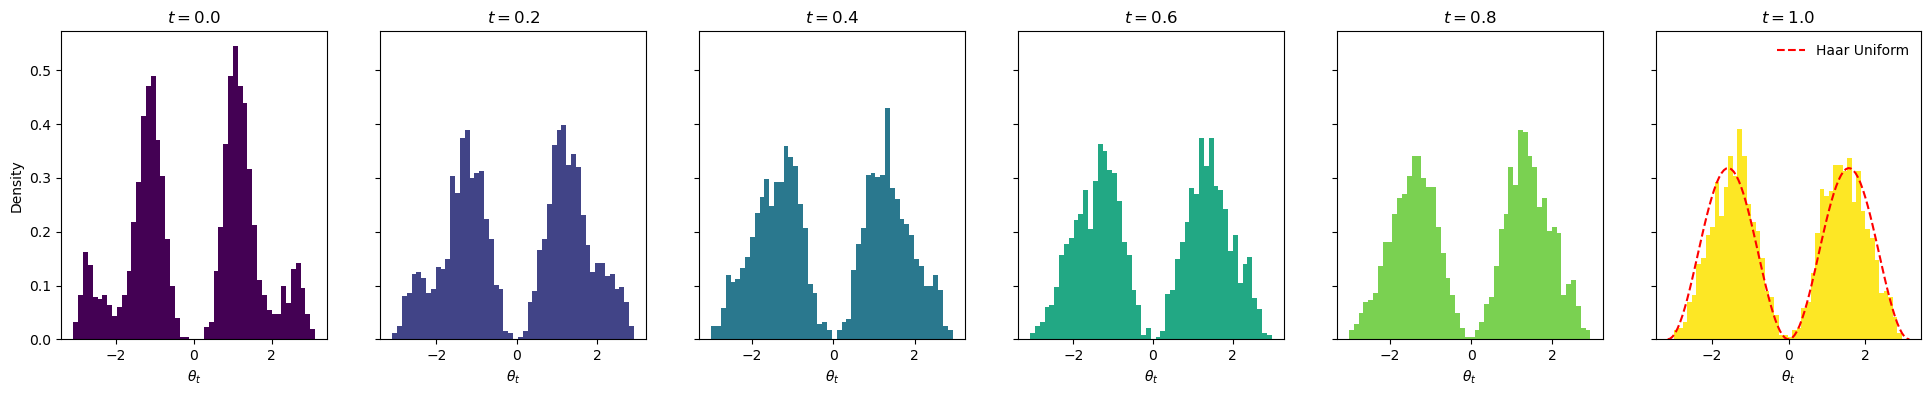

In [10]:
sigma = 1.1
diffuser = VarianceExpandingDiffusionSUN(sigma)

times = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
cmap = mpl.colormaps.get_cmap('viridis')
fig, axes = plt.subplots(1, len(times), figsize=(4*len(times), 4), sharey=True)
axes[0].set_ylabel('Density')
#axes[0].set_yscale('log')

U_0 = U_train.clone()
for t, ax in zip(times, axes):
    if t == 0:  # avoid sampling from HK at t=0
        x_t, _, _ = mat_angle(U_0)
    else:
        U_t, _, _ = diffuser.diffuse(U_0, t*torch.ones(U_0.size(0)), n_iter=20)
        x_t, _, _ = mat_angle(U_t)
    ax.hist(grab(x_t[:, :-1]), bins=50, density=True, color=cmap(t))
    ax.set_xlabel(r'$\theta_t$')
    ax.set_title(f'$t = {t}$')

# Plot uniform SU(2) Haar measure for comparison
xs = torch.linspace(-np.pi, np.pi, 100)
haar = (1 / np.pi) * torch.sin(xs)**2
axes[-1].plot(grab(xs), grab(haar), ls='--', color='red', label='Haar Uniform')
axes[-1].legend(frameon=False)

fig.show()

## Train a Score Network

Now we must construct a score network that will take as input the eigenangle $\theta$ and time $t$.

In [11]:
class SU2ScoreNet(torch.nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),  # 1 eigenangle + time = 2
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, 1))
        
    def forward(self, x_t, t):
        assert len(x_t.shape) == 2, \
            'input eigenangles shape should be [batch_size, Nc-1]'
        assert len(t.shape) == 1, \
            'times should only have a batch dimension'
        inp = torch.cat([x_t, t.unsqueeze(-1)], dim=-1)
        return self.net(inp)


def _test_su2_score_net():
    batch_size = 10
    Nc = 2
    x = 2*np.pi*torch.rand((batch_size, 1)) - np.pi
    t = torch.rand((batch_size,))
    s_t = SU2ScoreNet()(x, t)

    assert s_t.shape == x.shape, \
        '[FAILED: score net output must have same shape as input data]'
    print('[PASSED]')

_test_su2_score_net()

[PASSED]


In [13]:
def score_matching_loss_sun(U_0, diffuser, score_net, tol=1e-5):
    batch_size = U_0.size(0)
    t = tol + (1 - tol) * torch.rand((batch_size,))
    sigma_t = diffuser.sigma_func(t)

    U_t, xs, V = diffuser.diffuse(U_0, t, n_iter=10)
    x_0, _, _ = mat_angle(U_0)
    x_t, _, _ = mat_angle(U_t)
    x_t = x_t.to(dtype=t.dtype)

    score = score_net(x_t[..., :-1], t) / sigma_t.unsqueeze(-1)
    true_score = sun_score_hk_old(wrap(x_t[..., :-1] - x_0[..., :-1]), width=sigma_t)[..., :-1]
    #true_score = sun_score_hk(wrap(x_t[..., :-1] - x_0[..., :-1]), width=sigma_t)[..., :-1]

    diff = score - true_score
    loss = torch.mean(sigma_t.unsqueeze(-1)**2 * diff**2)

    if torch.isnan(loss) or loss.item() > 100:
        print('WARNING:', 'NaN' if torch.isnan(loss) else f'Loss blow-up! Loss = {loss.item()}')
        big_inds = torch.nonzero(torch.abs(diff) > 100)
        if big_inds.numel() > 0:
            for idx in big_inds:
                b, j = idx.tolist()
                print(f'  sample {b}, angle {j}:')
                print(f'    t = {t[b].item():.6f}')
                print(f'    x_t - x_0 = {wrap((x_t - x_0)[b, j]).item():.6f}')
                print(f'    score = {score[b, j].item():.6f}')
                print(f'    true_score = {true_score[b, j].item():.6f}')
                print(f'    diff = {diff[b, j].item():.6f}')
                print(f'    K(x_t, t) = {sun_hk(x_t, width=sigma_t)[b]}')
        else:
            print('  (no large diffs found)')
        print()

    return loss

In [14]:
from torch.utils.data import DataLoader, TensorDataset

# Make diffusion process
sigma = 1.1
score_net = SU2ScoreNet(input_dim=2, hidden_dim=64)
diffuser = VarianceExpandingDiffusionSUN(sigma)

# Setup training hyperparams
lr = 1e-3
epochs = 500
optimizer = torch.optim.Adam(params=score_net.parameters(), lr=lr)

# Prepare dataloader
batch_size = 512
dataset = TensorDataset(U_train) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=get_device()))

# Training loop
losses = []
score_net.train()
for epoch in tqdm.tqdm(range(epochs)):
    total_loss = 0.0
    for batch_idx, (U_0_batch,) in enumerate(dataloader):
        optimizer.zero_grad()
        loss = score_matching_loss_sun(U_0_batch, diffuser, score_net)
        if loss.item() > 100:  # for now: skip the unstable outliers
            continue
        if torch.isnan(loss):  # for now: skip NaNs
            continue
        torch.nn.utils.clip_grad_norm_(score_net.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch}/{epochs} | Loss = {avg_loss:.6f}')
    losses.append(avg_loss)

  0%|          | 0/500 [00:00<?, ?it/s]

/u/octavio5/projects/sun_diffusion/notebooks/../src/heat.py:449: RuntimeWarning: divide by zero encountered in divide
  p /= grab(sun_hk(torch.tensor(xs[..., :-1]), width=width, n_max=n_max))
/u/octavio5/projects/sun_diffusion/notebooks/../src/heat.py:449: RuntimeWarning: invalid value encountered in divide
  p /= grab(sun_hk(torch.tensor(xs[..., :-1]), width=width, n_max=n_max))


Epoch 0/500 | Loss = 1.402862
Epoch 1/500 | Loss = 1.390414
Epoch 2/500 | Loss = 1.442016
Epoch 3/500 | Loss = 1.349496
Epoch 4/500 | Loss = 1.357453
Epoch 5/500 | Loss = 1.447701
Epoch 6/500 | Loss = 1.310452
Epoch 7/500 | Loss = 1.366267
Epoch 8/500 | Loss = 1.349791
Epoch 9/500 | Loss = 1.425147
Epoch 10/500 | Loss = 1.342793
Epoch 11/500 | Loss = 1.414817


/u/octavio5/projects/sun_diffusion/notebooks/../src/heat.py:449: RuntimeWarning: overflow encountered in divide
  p /= grab(sun_hk(torch.tensor(xs[..., :-1]), width=width, n_max=n_max))


Epoch 12/500 | Loss = 1.342513
Epoch 13/500 | Loss = 1.346846
Epoch 14/500 | Loss = 1.257097
Epoch 15/500 | Loss = 1.340433
Epoch 16/500 | Loss = 1.405721
Epoch 17/500 | Loss = 1.255545
Epoch 18/500 | Loss = 1.289729
Epoch 19/500 | Loss = 1.352928
Epoch 20/500 | Loss = 1.292535
Epoch 21/500 | Loss = 1.345496
Epoch 22/500 | Loss = 1.334469
Epoch 23/500 | Loss = 1.199342
Epoch 24/500 | Loss = 1.370766
Epoch 25/500 | Loss = 1.324020
Epoch 26/500 | Loss = 1.262829
Epoch 27/500 | Loss = 1.350581
Epoch 28/500 | Loss = 1.265662
Epoch 29/500 | Loss = 1.286452
Epoch 30/500 | Loss = 1.286172
Epoch 31/500 | Loss = 1.275272
Epoch 32/500 | Loss = 1.322142
Epoch 33/500 | Loss = 1.376062
Epoch 34/500 | Loss = 1.317724
Epoch 35/500 | Loss = 1.308353
Epoch 36/500 | Loss = 1.251515
Epoch 37/500 | Loss = 1.277753
Epoch 38/500 | Loss = 1.167491
Epoch 39/500 | Loss = 1.312572
Epoch 40/500 | Loss = 1.341325
Epoch 41/500 | Loss = 1.220173
Epoch 42/500 | Loss = 1.275844
Epoch 43/500 | Loss = 1.281873
Epoch 44

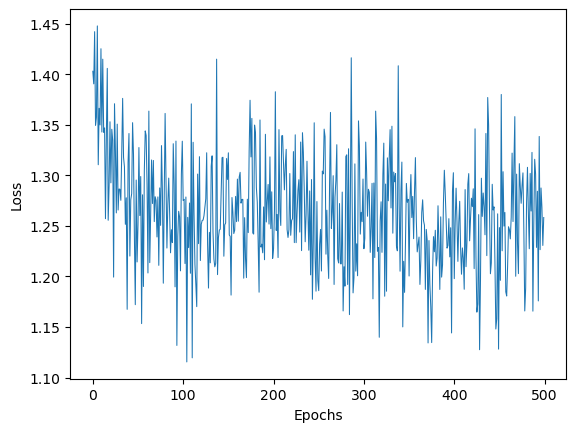

In [15]:
# Plot training loss vs epochs
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
#ax.set_yscale('log')
ax.plot(losses, lw=0.75)
fig.show()

## Denoising Process

Now we run the reverse process to generate new samples.

In [16]:
def sample_sun_gaussian(shape):
    Nc, Nc_ = shape[-2:]
    assert Nc == Nc_
    return proj_to_algebra(torch.randn(shape) + 1j*torch.randn(shape))

In [17]:
def compute_ess(logp, logq):
    logw = logp - logq
    log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
    return torch.exp(log_ess) / len(logw)


def compute_kl_div(logp, logq):
    # OV: reverse KL divergence since samples drawn from model q
    return torch.mean(logq - logp)

In [18]:
@torch.no_grad()
def solve_reverse_ODE(U_1, logr, score_net, diffuser, num_steps=200, verbose=False):
    trajectories = {
        'U_t': [],
        'logp': [],
        'logq': [],
        'kl_div': [],
        'ess': []
    }
    dt = 1 / num_steps
    t = 1.0
    U_t = U_1.clone()

    logJ = 0.
    for step in tqdm.tqdm(range(num_steps)):
        # Eigendecompose
        x_t, V, V_inv = mat_angle(U_t)

        # Get ODE params
        sigma_t = diffuser.sigma_func(t)
        g_t = diffuser.noise_coeff(t)
        score = score_net(x_t[..., :-1], t*torch.ones((U_t.size(0),))) / sigma_t

        # Skilling-Hutchinson Divergence Estimation
        func = lambda x: score_net(x, t*torch.ones((U_t.size(0),))) / sigma_t
        div = estimate_divergence(func, x_t[..., :-1], num_estimates=10)
        
        # Integration step in reverse time
        x_t = x_t + 0.5 * g_t**2 * score * dt
        logJ = logJ + 0.5 * g_t**2 * div * dt

        # Eigen-recomposition
        D = embed_diag(torch.exp(1j * x_t)).to(V)
        U_t = V @ D @ V_inv
        t -= dt

        # Collect and print metrics
        logp = -action(U_t)
        logq = logr - logJ
        kl_div = compute_kl_div(logp, logq).item()
        ess = compute_ess(logp, logq).item()
        if verbose:
            print(f'Step {step}/{num_steps}')
            print('logp =', logp.mean().item())
            print('logq =', logq.mean().item())
            print('Dkl =', kl_div)
            print('ESS =', ess)
            print()
        trajectories['U_t'].append(U_t)
        trajectories['logp'].append(logp.mean().item())
        trajectories['logq'].append(logq.mean().item())
        trajectories['kl_div'].append(kl_div)
        trajectories['ess'].append(ess)
 
    return U_t, logJ, trajectories

In [19]:
def log_haar_su2(x):
    """Computes log likelihood of SU(2) Haar uniform density."""
    x = x[:, 0]
    log_sin2 = 2*torch.log(torch.abs(torch.sin(x)))
    #log_norm = math.log(2 * np.pi**2)
    log_norm = math.log(np.pi)
    return log_sin2 - log_norm

In [20]:
# Initial data: 2x2 identity matrices
batch_size = 4096
Nc = 2
U_0 = U_train.clone()

# Diffuse: U_0 -> U_1
U_1, _, _ = diffuser.diffuse(U_0, torch.ones((U_0.size(0),)), n_iter=25)

In [21]:
# Get prior log likelihood
x_1, _, _ = mat_angle(U_1)
#logr = log_haar_su2(x_1)
logr = log_sun_hk(x_1, width=diffuser.sigma_func(1.0), eig_meas=False)
print('avg logr =', logr.mean().item())
print('std logr =', logr.std().item())

avg logr = -1.5406636526350164
std logr = 1.0314320884255783


In [22]:
U_0, logJ, history = solve_reverse_ODE(U_1, logr, score_net, diffuser, num_steps=500, verbose=True)

  0%|          | 0/500 [00:00<?, ?it/s]

Step 0/500
logp = -0.22532348020014892
logq = -1.5409236930338195
Dkl = -1.3156002128336706
ESS = 0.06273417455819841

Step 1/500
logp = -0.2253245222077218
logq = -1.5411842938842744
Dkl = -1.3158597716765525
ESS = 0.06276805000723464

Step 2/500
logp = -0.225326268130299
logq = -1.5414454468652163
Dkl = -1.3161191787349173
ESS = 0.06280205169107232

Step 3/500
logp = -0.22532872551653832
logq = -1.541707143610198
Dkl = -1.3163784180936595
ESS = 0.06283617920773196

Step 4/500
logp = -0.22533190190141006
logq = -1.5419693757079607
Dkl = -1.3166374738065505
ESS = 0.06287043215586058

Step 5/500
logp = -0.2253358048049665
logq = -1.5422321347029109
Dkl = -1.3168963298979444
ESS = 0.06290481013488256

Step 6/500
logp = -0.22534044173110296
logq = -1.5424954120956018
Dkl = -1.317154970364499
ESS = 0.06293931274515378

Step 7/500
logp = -0.2253458201663107
logq = -1.5427591993432208
Dkl = -1.31741337917691
ESS = 0.06297393958811574

Step 8/500
logp = -0.22535194757842153
logq = -1.54302348

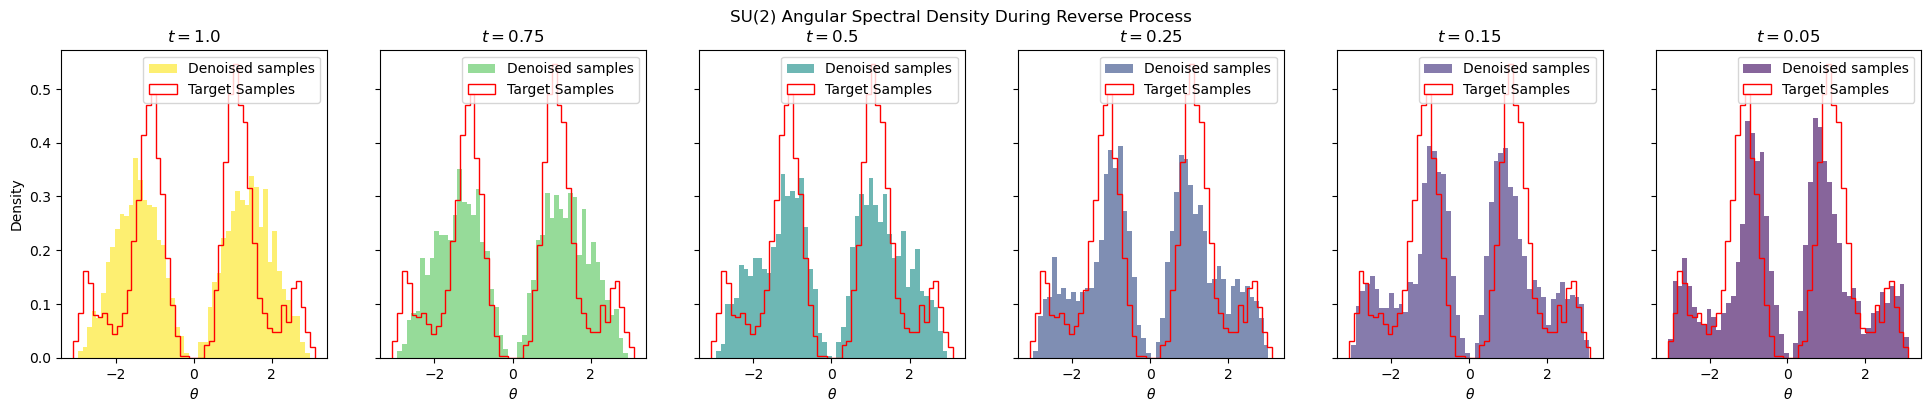

In [24]:
# Plot reverse trajectories
times = [1.0, 0.75, 0.5, 0.25, 0.15, 0.05]
cmap = mpl.colormaps.get_cmap('viridis')
fig, axes = plt.subplots(1, len(times), figsize=(4*len(times), 4), sharey=True)
fig.suptitle('SU(2) Angular Spectral Density During Reverse Process')
axes[0].set_ylabel('Density')
xs = torch.linspace(-np.pi, np.pi, 100).unsqueeze(-1)
for t, ax in zip(times, axes):
    # Histogram denoised samples
    step = int((1 - t) * len(history['U_t']))
    U_t = history['U_t'][step]
    x_t, _, _ = mat_angle(U_t)
    ax.hist(grab(x_t[:, 0]), bins=50, density=True, color=cmap(t), alpha=0.65, label='Denoised samples')
    ax.hist(grab(mat_angle(U_train)[0][:, 0]), bins=50, histtype='step', density=True, color='red', label='Target Samples')
    
    # Plot
    ax.set_title(f'$t = {t}$')
    ax.set_xlabel(r'$\theta$')
    ax.legend()
fig.show()

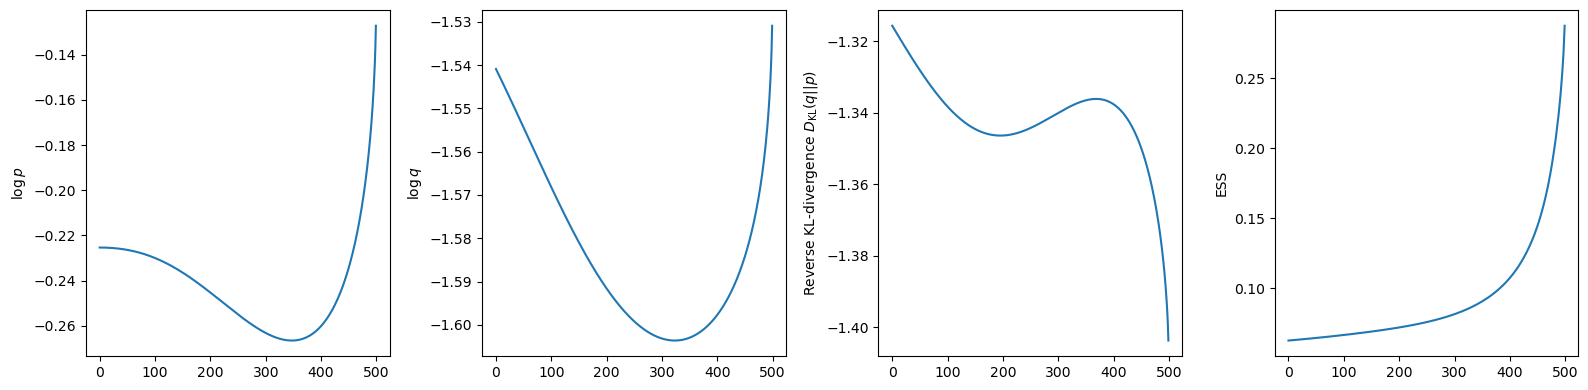

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].plot(history['logp'])
axes[0].set_ylabel(r'$\log p$')

axes[1].plot(history['logq'])
axes[1].set_ylabel(r'$\log q$')

axes[2].plot(history['kl_div'])
axes[2].set_ylabel(r'Reverse KL-divergence $D_{\rm KL}(q || p)$')

axes[3].plot(history['ess'])
axes[3].set_ylabel('ESS')

fig.tight_layout()
fig.show()

In [26]:
# Model likelihood
logq = logr - logJ
print('avg logq =', logq.mean().item())
print('std logq =', logq.std().item())

avg logq = -1.5309315612525773
std logq = 1.405500104794219


(array([440., 224.,  52.,  45.,  51.,  37.,  34.,  41.,  47.,  34.,  39.,
         34.,  29.,  38.,  27.,  28.,  25.,  32.,  31.,  27.,  25.,  31.,
         24.,  33.,  28.,  26.,  29.,  38.,  33.,  31.,  25.,  31.,  31.,
         31.,  30.,  25.,  31.,  19.,  22.,   7.,  16.,  14.,  12.,  16.,
         16.,  11.,  15.,  11.,  30.,  42.]),
 array([0.01715435, 0.04517922, 0.0732041 , 0.10122898, 0.12925386,
        0.15727874, 0.18530362, 0.2133285 , 0.24135338, 0.26937826,
        0.29740314, 0.32542802, 0.3534529 , 0.38147778, 0.40950266,
        0.43752754, 0.46555242, 0.4935773 , 0.52160218, 0.54962706,
        0.57765194, 0.60567682, 0.63370169, 0.66172657, 0.68975145,
        0.71777633, 0.74580121, 0.77382609, 0.80185097, 0.82987585,
        0.85790073, 0.88592561, 0.91395049, 0.94197537, 0.97000025,
        0.99802513, 1.02605001, 1.05407489, 1.08209977, 1.11012465,
        1.13814953, 1.16617441, 1.19419929, 1.22222416, 1.25024904,
        1.27827392, 1.3062988 , 1.33432368, 1.

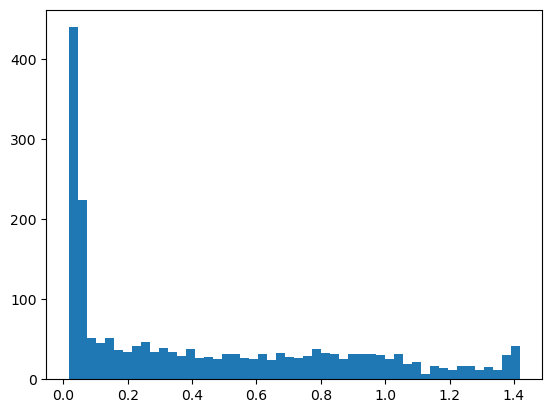

In [27]:
plt.hist(grab(logq.exp()), bins=50)

In [28]:
# TODO: check normalization of q over time
# bootstrap over samples -> errors
# calculate divergence explicitly

In [29]:
print(torch.mean(logq.exp()))

tensor(0.4505, device='cuda:0')


In [30]:
# Target likelihood
logp = -action(U_0)
print('avg logp =', logp.mean().item())
print('std logp =', logp.std().item())

avg logp = -0.12714829722996773
std logp = 0.5386179047980117


In [31]:
# Effective Sample Size
print('ESS = ', compute_ess(logp, logq).item())

ESS =  0.2873133787163335
